In [187]:
import os.path
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build


In [188]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# Config
f = open('config.json', 'r')
CONFIG = json.loads(f.read())
f.close()

SPREADSHEET_ID = CONFIG['sheet_id']
SHEET = CONFIG['sheet']
DATA_TO_PULL ='Sheet1!A1:E40'


In [189]:
def gsheet_api_check(SCOPES):
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return creds

def pull_sheet_data(SCOPES,SPREADSHEET_ID,DATA_TO_PULL):
    print('Connecting to Google Sheets Service')
    print('Authenticating')
    creds = gsheet_api_check(SCOPES)
    print('Retrieving Data')
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(
        spreadsheetId=SPREADSHEET_ID,
        range=DATA_TO_PULL).execute()
    values = result.get('values', [])
    
    if not values:
        print('No data found.')
    else:
        rows = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                  range=DATA_TO_PULL).execute()
        data = rows.get('values')
        print("Finished: Data copied")
        print('Disconnecting from Google Sheets Service')
        return data

# Example Spreadsheet

Here we have an example financial tracker spreadsheet

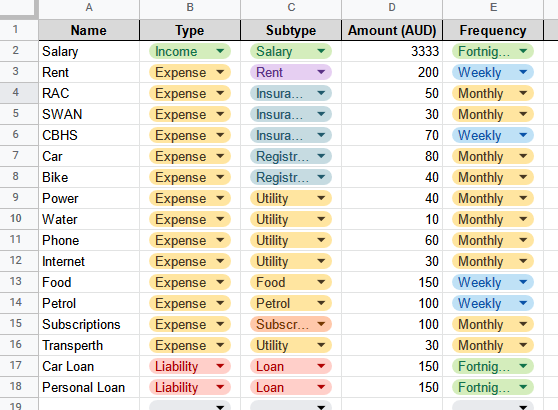

# Lets pull in the data using the Google Sheets API

In [190]:
data = pull_sheet_data(SCOPES,SPREADSHEET_ID,DATA_TO_PULL)

Connecting to Google Sheets Service
Authenticating
Retrieving Data
Finished: Data copied
Disconnecting from Google Sheets Service


# And look at it with a Pandas Dataframe

In [191]:
df = pd.DataFrame(data[1:], columns=data[0])
df

,Name,Type,Subtype,Amount (AUD),Frequency
0,Salary,Income,Salary,3333,Fortnightly
1,Rent,Expense,Rent,200,Weekly
2,RAC,Expense,Insurance,50,Monthly
3,SWAN,Expense,Insurance,30,Monthly
4,CBHS,Expense,Insurance,70,Weekly
5,Car,Expense,Registration,80,Monthly
6,Bike,Expense,Registration,40,Monthly
7,Power,Expense,Utility,40,Monthly
8,Water,Expense,Utility,10,Monthly
9,Phone,Expense,Utility,60,Monthly


# Here I've created a class for no reason because im an ~~idiot~~

In [192]:
class Transaction():

    def __init__(self, name, type, subtype, amount, frequency):
        self.name = name
        self.type = type
        self.subtype = subtype
        self.amount = float(amount)
        self.frequency = frequency
    
    def get_name(self):
        return self.name

    def get_type(self):
        return self.type

    def get_subtype(self):
        return self.subtype

    def get_amount(self):
        return self.amount

    def get_frequency(self):
        return self.frequency
    
    def get_monthly_amount(self):
        amt = 0.0
        match self.frequency:
            case 'Weekly':
                amt = self.amount * 4.0
            case 'Fortnightly':
                amt = self.amount * 2.0
            case 'Monthly':
                amt = self.amount
            case 'Annually':
                amt = self.amount/12.0
        return round(amt, 2)
    
    def convert_to_monthly(self):
        self.amount = self.get_monthly_amount()
        self.frequency = 'Monthly'

    def __str__(self):
        return f'{self.type} - {self.subtype} - {self.name} - {self.amount} - {self.frequency}'

transactions = []
for i, row in df.iterrows():
    transaction = Transaction(row['Name'], row['Type'], row['Subtype'], row['Amount (AUD)'], row['Frequency'])
    transaction.convert_to_monthly()
    transactions.append(transaction)

#### I don't want to talk about it

In [193]:
incomes = 0
expenses = 0
liabilities = 0

for x in transactions:
    match x.get_type():
        case "Income":
            incomes += x.get_amount()
        case "Expense":
            expenses += x.get_amount()
        case "Liability":
            liabilities += x.get_amount()

print(f'Income: {incomes}')
print(f'Expenses: {expenses}')
print(f'Liabilities: {liabilities}')


Income: 6666.0
Expenses: 2550.0
Liabilities: 600.0


# Yay a graph

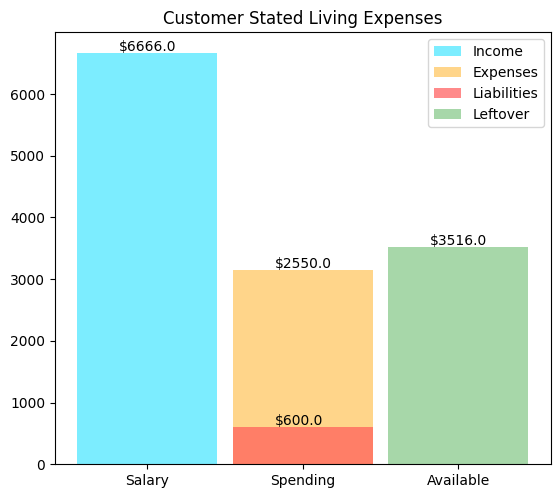

In [228]:
plt.bar(1, incomes, width = 0.9, color = (0.27, 0.90, 1.00, 0.7), label='Income')
plt.bar(2, expenses + liabilities, width = 0.9, color=(1.00, 0.77, 0.35, 0.70), label='Expenses')
plt.bar(2, liabilities, width = 0.9, color = (1.00, 0.35, 0.35, 0.70), label='Liabilities')
plt.bar(3, incomes - (expenses + liabilities), width = 0.9, color=(0.51, 0.78, 0.52, 0.70), label='Leftover')

plt.legend()

plt.text(x= 0.82, y= incomes + 30, s = f'${incomes}')
plt.text(x= 1.82, y= expenses + liabilities + 30, s = f'${expenses}')
plt.text(x= 1.82, y= liabilities + 30, s = f'${liabilities}')
plt.text(x= 2.82, y= incomes - (expenses + liabilities) + 30, s = f'${incomes - (expenses + liabilities)}')

plt.subplots_adjust(bottom= 0.1, top = 1.0)

plt.xticks([1, 2, 3], ['Salary', 'Spending', 'Available'])

plt.title('Customer Stated Living Expenses')

plt.show()

# Yay a Pie

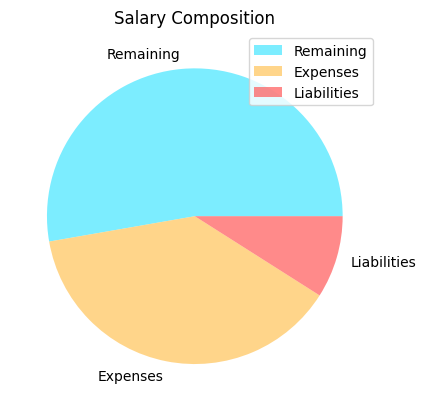

In [227]:
plt.pie([incomes - (expenses + liabilities), expenses, liabilities],
    labels = ['Remaining', 'Expenses', 'Liabilities'],
    colors = [ (0.27, 0.90, 1.00, 0.7) , (1.00, 0.77, 0.35, 0.70), (1.00, 0.35, 0.35, 0.70)],
    
    )

plt.title('Salary Composition')

plt.show()

# A Cooler Pie

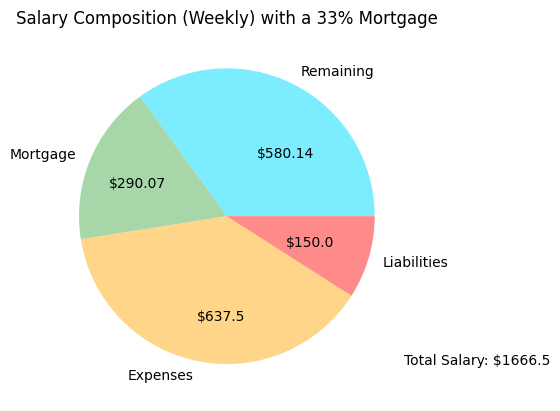

In [284]:
remaining = incomes - (expenses + liabilities)
remaining = remaining//4
plt.pie([remaining * 0.66, remaining * 0.33, expenses/4, liabilities/4],
    labels = ['Remaining', 'Mortgage', 'Expenses', 'Liabilities'],
    colors = [ (0.27, 0.90, 1.00, 0.7), (0.51, 0.78, 0.52, 0.70), (1.00, 0.77, 0.35, 0.70), (1.00, 0.35, 0.35, 0.70)],
    
    )

plt.title('Salary Composition (Weekly) with a 33% Mortgage')
plt.annotate(f'${remaining * 0.66}', xy=[0.2, 0.4])
plt.annotate(f'${remaining * 0.33}', xy=[-0.8, 0.2])
plt.annotate(f'${expenses/4}', xy=[-0.2, -0.7])
plt.annotate(f'${liabilities/4}', xy=[0.4, -0.2])

plt.annotate(f'Total Salary: ${incomes/4}', xy=[1.2, -1])


plt.show()